## Experiment 2
Conditions: pair of sensors approx 3 cm apart, waving hand over sensor.

Compared to experiment 1, readings are much closer together in time only 3 cm apart, will make determining order of triggering much harder

In [1]:
# from lidar_x2_csv import CSV_COLUMNS, CAPTURE_HZ, CAPTURE_MINUTES, READINGS

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

FIG_WIDTH = 22
FIG_HEIGHT = 4
FIG_SIZE = (FIG_WIDTH, FIG_HEIGHT)

In [3]:
ls *.csv

data_2019-05-01_17:27.csv


In [4]:
csv_path = "data_2019-05-01_17:27.csv"
df = pd.read_csv(csv_path, index_col=0)

In [5]:
df.index = pd.to_datetime(df.index)

In [6]:
df.head()

LIDAR_1  LIDAR_2
time                                        
2019-05-01 17:27:42.854255      203        0
2019-05-01 17:27:42.956440      203      199
2019-05-01 17:27:43.070316      203      199
2019-05-01 17:27:43.184786      203      199
2019-05-01 17:27:43.301092      203      199

In [7]:
data_points = df.shape[0]
data_points

600

## Raw data
Readings are in distance, where 200 is 2meter distance to roof

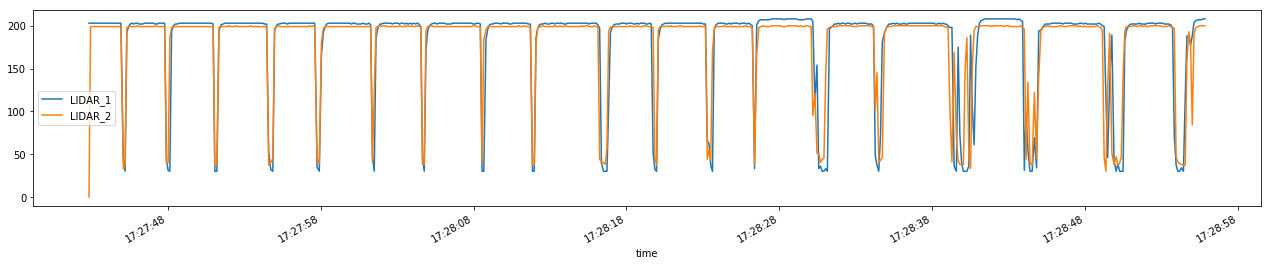

In [8]:
df.plot(figsize=FIG_SIZE); # 

We want to identify changes to the height, so take the diff

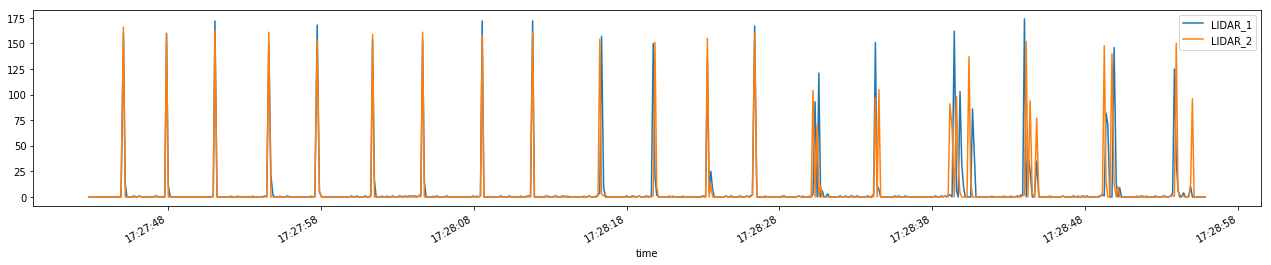

In [9]:
df_diff = df.diff()[df.diff() < 1].abs() # get the negative diffs (as data is inverted) and take the abs to get a positive height
df_diff = df_diff.fillna(0)
df_diff.plot(figsize=FIG_SIZE);

We want to identify pairs of events, which when highly correlated in time are likely a single detection event. Use `rolling` to generate a moving window with some statistic that can be used to identify these events -> choose `max`

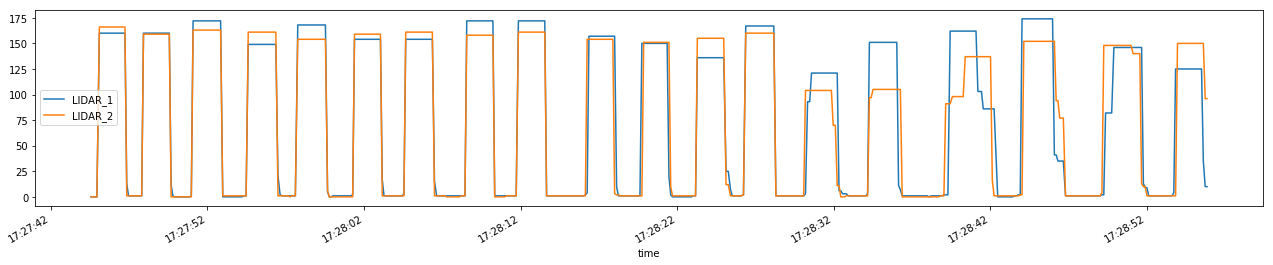

In [10]:
WINDOW = 15 # the number of points in a rolling window - this becomes the hyperparameter to tune

df_diff_rolling_max = df_diff.rolling(WINDOW).max()
df_diff_rolling_max.plot(figsize=FIG_SIZE);

We dont need this window if a person can break both beams at once - achieve by having sensors closer together

## Candidate detection events
When both values are high, the product will be very high -> use to identify detection events

In [11]:
df_diff_rolling_max['product'] = df_diff_rolling_max['LIDAR_1'] * df_diff_rolling_max['LIDAR_2']

Plot candidate detection events

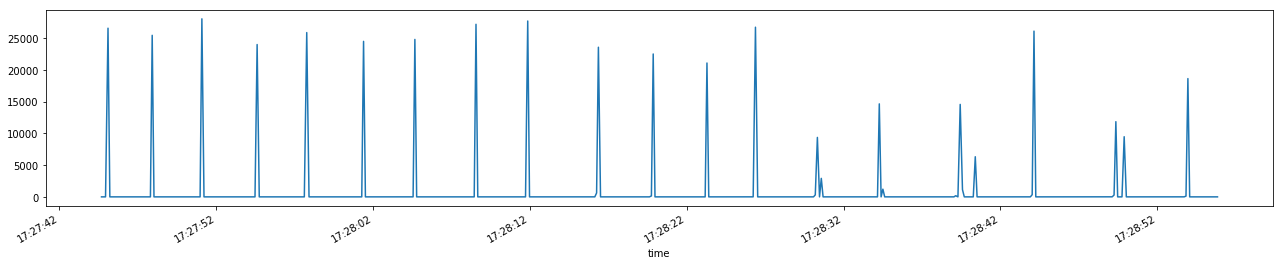

In [12]:
df_diff_product = df_diff_rolling_max['product'].diff()
df_diff_product[df_diff_product < 0] = 0 # drop negative values
df_diff_product.plot(figsize=FIG_SIZE);

Get the events based on the `df_diff_product`

In [13]:
events = list(df_diff_product[df_diff_product > 10000].index)
events

[Timestamp('2019-05-01 17:27:45.098079'),
 Timestamp('2019-05-01 17:27:47.915592'),
 Timestamp('2019-05-01 17:27:51.083198'),
 Timestamp('2019-05-01 17:27:54.605240'),
 Timestamp('2019-05-01 17:27:57.768461'),
 Timestamp('2019-05-01 17:28:01.390827'),
 Timestamp('2019-05-01 17:28:04.662955'),
 Timestamp('2019-05-01 17:28:08.559780'),
 Timestamp('2019-05-01 17:28:11.857967'),
 Timestamp('2019-05-01 17:28:16.364133'),
 Timestamp('2019-05-01 17:28:19.858105'),
 Timestamp('2019-05-01 17:28:23.285272'),
 Timestamp('2019-05-01 17:28:26.377448'),
 Timestamp('2019-05-01 17:28:34.272664'),
 Timestamp('2019-05-01 17:28:39.430514'),
 Timestamp('2019-05-01 17:28:44.135217'),
 Timestamp('2019-05-01 17:28:49.355359'),
 Timestamp('2019-05-01 17:28:53.947833')]

In [14]:
df_diff_product.shape

(600,)

And compare to our original diff

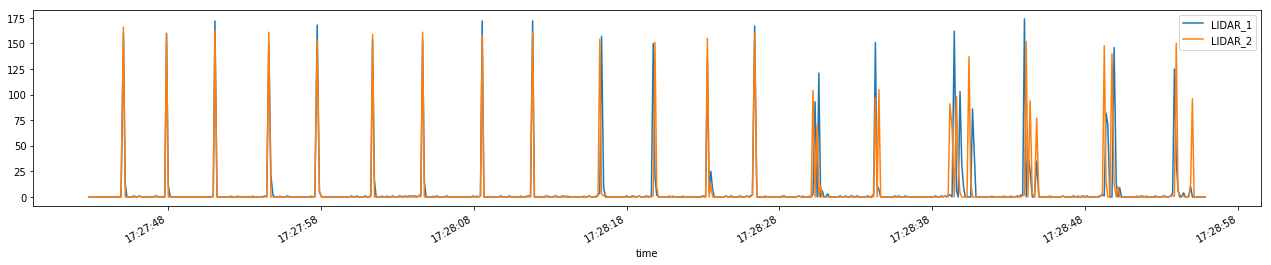

In [15]:
df_diff.plot(figsize=FIG_SIZE);

## Determine order of events
Now want to find the closest signals to events, and determine their order, to decided it if it was an ENTRANCE or EXIT event

* ENTRANCE -> LIDAR_1 was high before LIDAR_2
* EXIT -> LIDAR_2 was high before LIDAR_1

Can we use the 'last triggered' sensor to determine the direction of travel?

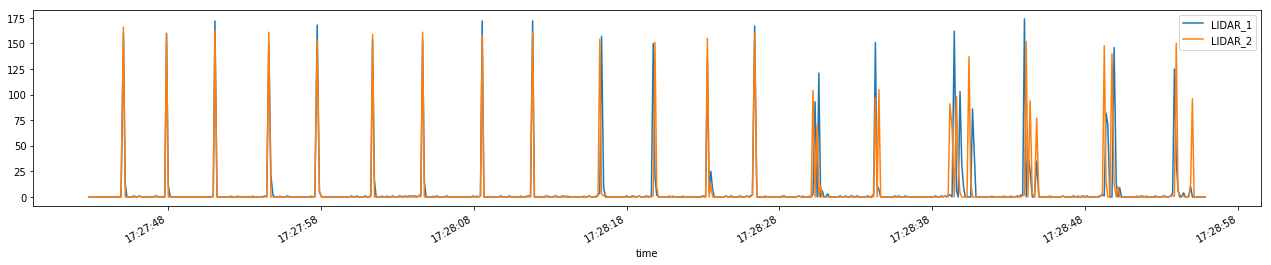

In [16]:
df_diff.plot(figsize=FIG_SIZE);

Write an algo to determine the last triggered sensor

In [17]:
initial_state = 0
states = [initial_state] # initialise an empty state

# iterate over times and determine state at each time
for time in df_diff.index:
    if df_diff.loc[time]['LIDAR_1'] > 50:
        states.append(0)
    elif df_diff.loc[time]['LIDAR_2'] > 50:
        states.append(1)
    else:
        states.append(states[-1]) # append the previous state

states = states[1:] # drop that initial_state

In [18]:
ds_state = pd.Series(data=states, index=df_diff.index)

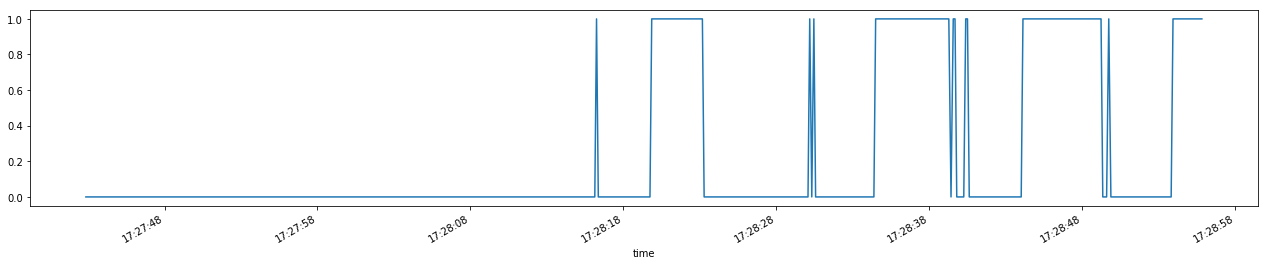

In [19]:
ds_state.plot(figsize=FIG_SIZE);

Half-way through the run I slowed down my hand movement, making detection of events easier

Now we can look up the last triggered sensor at each event

In [20]:
ds_state.loc[events]

time
2019-05-01 17:27:45.098079    0
2019-05-01 17:27:47.915592    0
2019-05-01 17:27:51.083198    0
2019-05-01 17:27:54.605240    0
2019-05-01 17:27:57.768461    0
2019-05-01 17:28:01.390827    0
2019-05-01 17:28:04.662955    0
2019-05-01 17:28:08.559780    0
2019-05-01 17:28:11.857967    0
2019-05-01 17:28:16.364133    0
2019-05-01 17:28:19.858105    1
2019-05-01 17:28:23.285272    0
2019-05-01 17:28:26.377448    0
2019-05-01 17:28:34.272664    0
2019-05-01 17:28:39.430514    0
2019-05-01 17:28:44.135217    1
2019-05-01 17:28:49.355359    0
2019-05-01 17:28:53.947833    1
dtype: int64

Detection much worse than Experiment 1 due to closeness of events

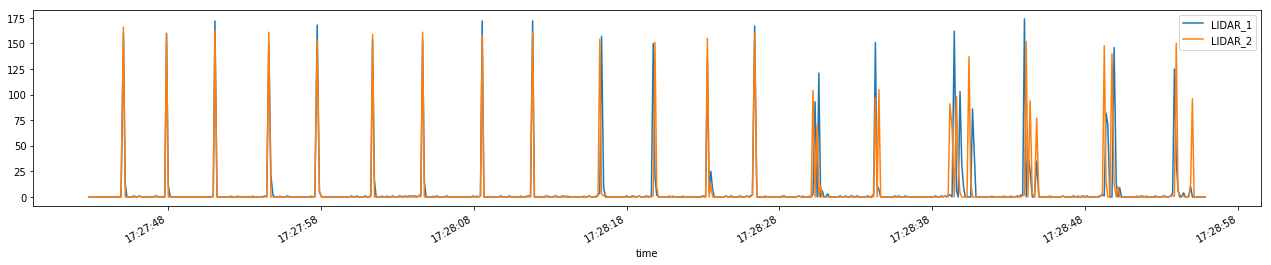

In [21]:
df_diff.plot(figsize=FIG_SIZE);